In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from libtiff import TIFF
import cv2
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

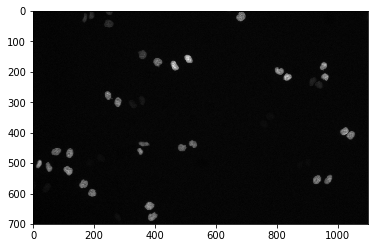

In [36]:
# Generate an initial image with two overlapping circles
tif = TIFF.open('t200.tif',mode='r')
image = tif.read_image()

plt.imshow(image, cmap=plt.cm.gray)

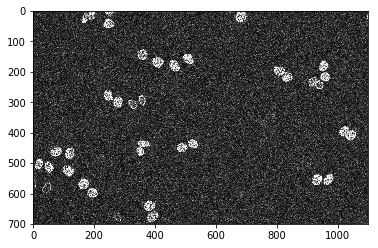

In [37]:
#code from Yunfan

sobelX = cv2.Sobel(image,cv2.CV_64F,1,0)#x方向的梯度
sobelY = cv2.Sobel(image,cv2.CV_64F,0,1)#y方向的梯度
sobelX = np.uint8(np.absolute(sobelX))#x方向梯度的绝对值
sobelY = np.uint8(np.absolute(sobelY))#y方向梯度的绝对值
sobel = cv2.bitwise_or(sobelX,sobelY)

plt.imshow(sobel, cmap=plt.cm.gray)

In [38]:
#image = cv2.bilateralFilter(image,9,75,75)

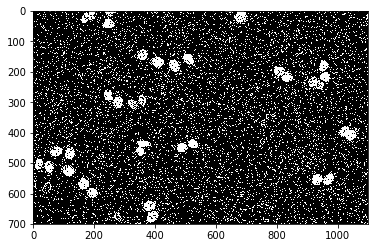

In [39]:
_, threshold = cv2.threshold(sobel, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.imshow(threshold, cmap=plt.cm.gray)

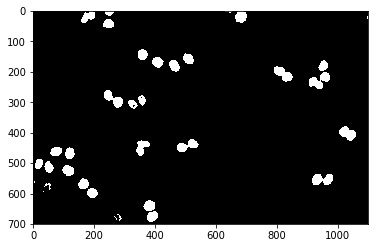

In [40]:
medianblur = cv2.medianBlur(threshold, 9)#t200

plt.imshow(medianblur, cmap=plt.cm.gray)

In [41]:
#kernel = np.ones((3,3), np.uint8)
#image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
#image = cv2.GaussianBlur(image,(9,9),0)

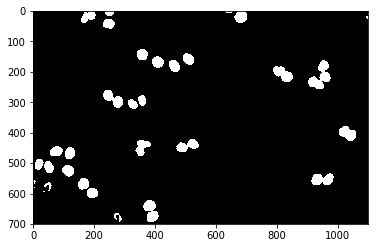

In [42]:
fir_dilate = cv2.dilate(medianblur, np.ones((3,3), np.uint8))

plt.imshow(fir_dilate, cmap=plt.cm.gray)

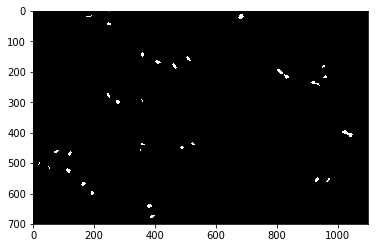

In [43]:
erode = cv2.erode(fir_dilate, np.ones((19,19), np.uint8))

plt.imshow(erode, cmap=plt.cm.gray)

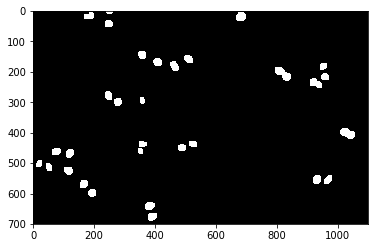

In [54]:
sec_dilate = cv2.dilate(erode, np.ones((13,13), np.uint8))

plt.imshow(sec_dilate, cmap=plt.cm.gray)

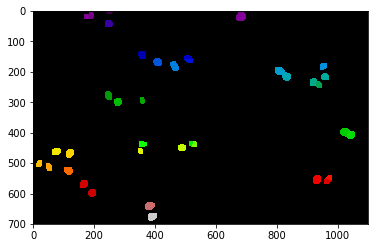

In [32]:
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(sec_dilate.copy())
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((9, 9)),
                            labels=sec_dilate)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=sec_dilate)

plt.imshow(labels, cmap=plt.cm.nipy_spectral)

In [27]:
print(np.max(labels),np.min(labels))

38 0


In [28]:
print(sec_dilate)
print(np.max(sec_dilate),np.min(sec_dilate))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
1 0


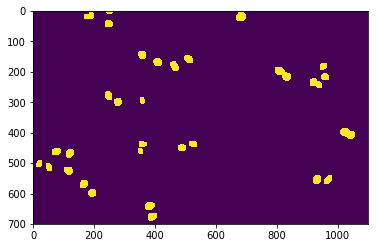

In [29]:
plt.imshow(sec_dilate)

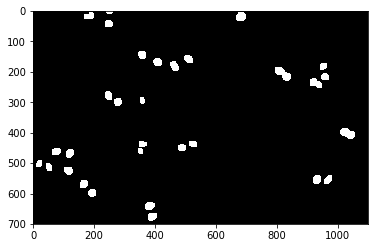

In [55]:
#code from Jiadai

IMG_OUT = cv2.cvtColor(sec_dilate, cv2.COLOR_GRAY2RGB)
plt.imshow(IMG_OUT,'gray')

In [58]:
#code from Jiadai

(_, cnts, _) = cv2.findContours(sec_dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
c = sorted(cnts, key=cv2.contourArea, reverse=True)
draw_img = IMG_OUT.copy()

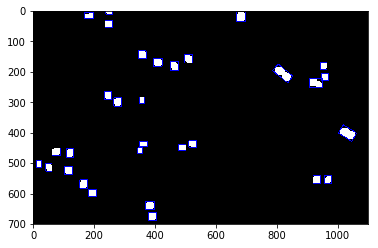

In [59]:
#code from Jiadai

for i in range(len(c)):
    rect = cv2.minAreaRect(c[i])
    box = np.int0(cv2.boxPoints(rect))
    draw_img = cv2.drawContours(draw_img, [box], -1, (0, 0, 255),2)

plt.imshow(draw_img,'gray')

In [48]:
#number of cells 
#but wrong number...

print(len(cnts)-1) 

30


In [49]:
#label the cells

for i,j in zip(cnts,range(len(cnts))):
    M = cv2.moments(i)
    cX = int(M["m10"]/M["m00"])
    cY = int(M["m01"]/M["m00"])
    count=cv2.putText(draw_img,str(j),(cX,cY),1,1,(255,0,255),1)

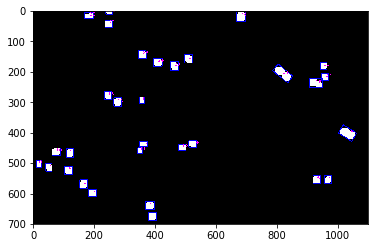

In [50]:
plt.imshow(count,'gray') # cell with number